HW4 <br>
Question: 1 <br>
Mahdi Koloushani <br>
401300066

در بخش هایی از این سوال، از کدها و توابع موجود در سایت پایتورچ استفاده شده است

In [1]:
import torch
from io import open
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
! pip -q install --upgrade --no-cache-dir gdown

In [3]:
!gdown 1o88B-biyIpjBIhqd_VWjVHnWFswjPgwY

Downloading...
From: https://drive.google.com/uc?id=1o88B-biyIpjBIhqd_VWjVHnWFswjPgwY
To: /content/ferdousi.txt
100% 4.54M/4.54M [00:00<00:00, 20.2MB/s]


## Data Loading 

In [4]:
lines = open('ferdousi.txt' , encoding='utf-8').read().strip().split('\n')
lines = lines[2:-1]

### Creating Datasets

In [5]:
pairs = []
for c in range(0,len(lines),2):
    pairs.append([lines[c], lines[c+1]])

## Shuffling Data
random.shuffle(pairs)


### Defining Class of Dictionary

In [6]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Get instance of Lang class and complete dictionary with all of the dataset

In [7]:
poem = Lang("poem")
def prepareData(pairs):
    for pair in pairs:
        poem.addSentence(pair[0])
        poem.addSentence(pair[1])
    print("Counted words:")
    print(poem.name, poem.n_words)


prepareData(pairs)

Counted words:
poem 18013


Check an Example



In [8]:
word2index = poem.word2index
word2count = poem.word2count
index2word = poem.index2word

In [9]:
i = "سهراب"
print(f"index = {word2index[i]}, number of repetition = {word2count[i]}")
#index2word[i])

index = 1529, number of repetition = 81


### Defining Required Functions for converting 

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(poem, pair[0])
    target_tensor = tensorFromSentence(poem, pair[1])
    return (input_tensor, target_tensor)

### Convert Pairs to Tensors

In [11]:
training_pairs = [tensorsFromPair(i) for i in pairs]

### Defining a train function

In [12]:
loss_fn = nn.CrossEntropyLoss()
def train (Data, Encoder, Decoder, Enc_opt, Dec_opt , epochs, Max_Length ): 
  loss_seq = []
  acc_seq = []
  loss_epoch = []
  acc_epoch = []
  for epoch in range(epochs):
    print(f"Epoch = {epoch+1}")
    random.shuffle(Data)
    total_loss = 0
    total_acc = 0
    for j in range(len(Data)):
        training_pair = Data[j]
        input_sen = training_pair[0]
        target_sen = training_pair[1]
        
        
        encoder_hidden = Encoder.initHidden()
        
        Enc_opt.zero_grad()
        Dec_opt.zero_grad()

        input_length = input_sen.size(0)
        target_length = target_sen.size(0)

        encoder_outputs = torch.zeros(Max_Length, Encoder.hidden_size, device=device)

        
        ## Encoder       
        for i in range(input_length):
            encoder_output, encoder_hidden = Encoder(input_sen[i], encoder_hidden)## check the dimention of the encoder output

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden
        
        loss = 0
        Acc = 0
        ## Decoder
        
        for i in range(target_length):
            decoder_output, decoder_hidden = Decoder(decoder_input, decoder_hidden)
            loss += loss_fn(decoder_output, target_sen[i])
            Acc += (torch.argmax(decoder_output) ==  target_sen[i][0])
            decoder_input = target_sen[i] ## Teacher Forcing
        
        total_loss += loss.item()/target_length
        total_acc += Acc.item()/target_length
        loss.backward()

        Enc_opt.step()
        Dec_opt.step()
        
        if j % 500  == 0 and j!=0:
            avg_loss = total_loss / 500
            avg_acc = total_acc/500

            print(f"Average Loss = {avg_loss} Average Acc = {avg_acc}")

            total_loss = 0
            total_acc = 0
            loss_seq.append(avg_loss)
            acc_seq.append(avg_acc)        
    loss_epoch.append(avg_loss)
    acc_epoch.append(avg_acc)
  return loss_epoch, loss_seq, acc_epoch, acc_seq


## PART A: a seq2seq Model with LSTM

### LSTM Encoder

In [13]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout = 0.5)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device))

### LSTM Decoder

In [14]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout = 0.5)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = nn.functional.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training for LSTM

In [18]:
hidden_size = 256
lr = 0.001
max_length = 15
epochs = 5

encoderLstm = EncoderLSTM(poem.n_words, hidden_size)
decoderLstm = DecoderLSTM(hidden_size, poem.n_words)
encoderLstm = encoderLstm.to(device)
decoderLstm = decoderLstm.to(device)

encoder_optimizer = torch.optim.Adam(encoderLstm.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoderLstm.parameters(), lr=lr)
Loss_epoch_lstm, Loss_seq_lstm, Acc_epoch_lstm, Acc_seq_lstm = train (training_pairs, encoderLstm, decoderLstm, encoder_optimizer, decoder_optimizer , epochs, max_length )

Epoch = 1
Average Loss = 7.097215918159481 Average Acc = 0.1843857142857148
Average Loss = 6.503751371020362 Average Acc = 0.18472936507936558
Average Loss = 6.413637738086106 Average Acc = 0.19505173160173234
Average Loss = 6.315066386038161 Average Acc = 0.19498968253968313
Average Loss = 6.242479250516517 Average Acc = 0.18725101010101047
Average Loss = 6.0834881918104875 Average Acc = 0.19229920634920683
Average Loss = 6.1415210479901505 Average Acc = 0.20073896103896144
Average Loss = 6.136834642210462 Average Acc = 0.19511825396825455
Average Loss = 6.136729304232736 Average Acc = 0.20185490620490668
Average Loss = 6.049216059345674 Average Acc = 0.20019841269841335
Average Loss = 6.042372158374623 Average Acc = 0.20020901875901928
Average Loss = 6.0195616450688165 Average Acc = 0.20314285714285762
Average Loss = 6.012751920369377 Average Acc = 0.20727402597402636
Average Loss = 5.908889520757161 Average Acc = 0.20437857142857216
Average Loss = 5.914112712661802 Average Acc = 0.2

## Save the model

In [19]:
torch.save(encoderLstm.state_dict(),"EncoderLstmQ1")
torch.save(decoderLstm.state_dict(),"DecoderLstmQ1")

### Save the loss sequences

In [20]:
np.save("Loss_epoch_lstm.npy",np.array(Loss_epoch_lstm))
np.save("Loss_seq_lstm.npy",np.array(Loss_seq_lstm))

### Save Accuracy

In [21]:
np.save("Acc_epoch_lstm.npy",np.array(Acc_epoch_lstm))
np.save("Acc_seq_lstm.npy",np.array(Acc_seq_lstm))

### Load the loss sequences

In [22]:
Loss_epoch = np.load("Loss_epoch_lstm.npy")
Loss_seq = np.load("Loss_seq_lstm.npy")

### Load the Acc sequence

In [23]:
Acc_epoch = np.load("Acc_epoch_lstm.npy")
Acc_seq = np.load("Acc_seq_lstm.npy")

### Load the stored model

In [24]:
# EncoderLoaded = EncoderLSTM(poem.n_words, hidden_size)

# EncoderLoaded.load_state_dict(torch.load("EncoderLstmQ1"))

# DecoderLoaded = DecoderLSTM(poem.n_words, hidden_size)

# DecoderLoaded.load_state_dict(torch.load("DecoderLstmQ1"))

### Plot Loss Sequence through all the epochs

Text(0.5, 0, 'Every 500 data')

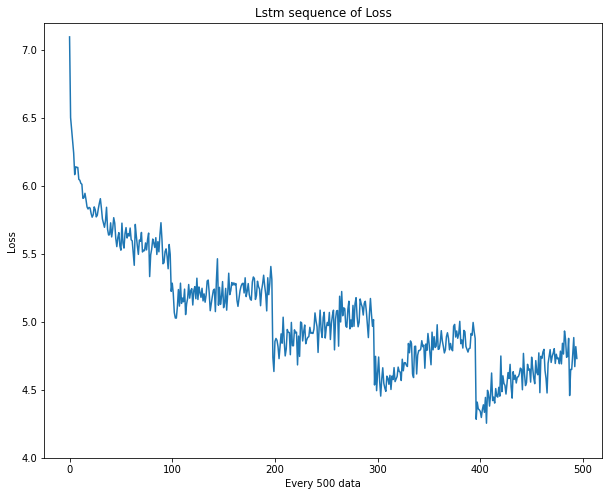

In [26]:
plt.figure(figsize=(10,8))
plt.plot(Loss_seq)
plt.title("Lstm sequence of Loss")
plt.ylim([4,7.2])
plt.ylabel('Loss')
plt.xlabel('Every 500 data')

### Plot Accuracies Sequence through all the epochs

Text(0.5, 0, 'Every 500 data')

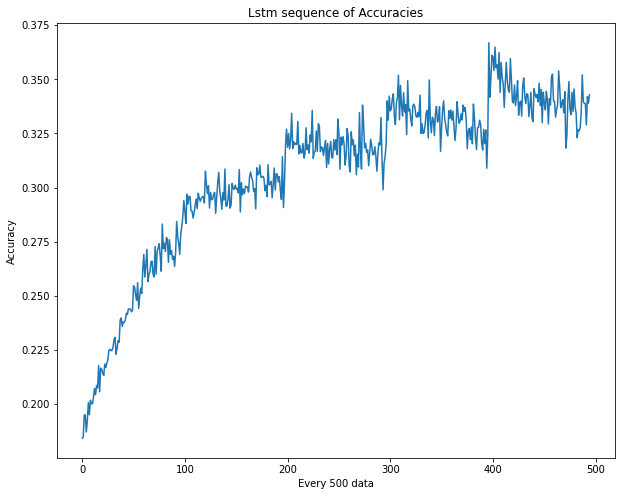

In [28]:
plt.figure(figsize=(10,8))
plt.plot(Acc_seq)
plt.title("Lstm sequence of Accuracies")
plt.ylabel('Accuracy')
plt.xlabel('Every 500 data')

متاسفانه به دلیل کمبود وقت و محدودیت های کولب، قادر به ران کردن برای تعداد زیاد ایپاک نبودم، اما برای تعداد 10 ایپاک به لاس حدود 2 و خرده ای و دقت حدود 50 درصد رسید

## Evaluation of the model

In [29]:
loss_fn = nn.CrossEntropyLoss()
def Evaluate(Encoder, Decoder, Sentence, Max_Length,poem): 
        training_pair = tensorFromSentence(poem,Sentence)
        input_sen = training_pair[0].to(device=device)
        target_sen = training_pair[1].to(device=device)
        
        
        encoder_hidden = Encoder.initHidden()
        
   
        input_length = input_sen.size(0)

        encoder_outputs = torch.zeros(Max_Length, Encoder.hidden_size, device=device)

        
        ## Encoder       
        for i in range(input_length):
            encoder_output, encoder_hidden = Encoder(input_sen[i], encoder_hidden)## check the dimention of the encoder output

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []
        
        ## Decoder
        for i in range(max_length):
            decoder_output, decoder_hidden = Decoder(decoder_input, decoder_hidden)
            yhat = torch.argmax(decoder_output)
            if yhat == torch.tensor([[EOS_token]], device=device):
                break
            else:    
                decoded_words.append(poem.index2word[yhat.item()])  

            decoder_input = torch.tensor([yhat]).to(device=device) ## Teacher Forcing
        return decoded_words


In [30]:
def ListToSentence(InputWord):
    temp = ""
    for i in InputWord:
        temp += f"{i} "
    return temp

مثالی از ارزیابی (ال اس تی ام)

In [37]:
sentence = "خرد تیره و مرد روشن روان"

print("input sentence")
print(sentence)
print("LSTM output:")
print(ListToSentence(Evaluate(Encoder = encoderLstm,Decoder = decoderLstm,Sentence = sentence, Max_Length = max_length, poem = poem)))

input sentence
خرد تیره و مرد روشن روان
LSTM output:
از باد و رای و دل رای 


## PART B: a seq2seq Model with GRU

### Bidirectional GRU Encoder

In [38]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)

### Bidirectional GRU Decoder

In [39]:
class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True)
        self.out = nn.Linear(2*hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training for GRU

In [40]:
hidden_size = 256
lr = 0.001
max_length = 15
epochs = 5


encoderGru = EncoderGRU(poem.n_words, hidden_size)
decoderGru = DecoderGRU(hidden_size, poem.n_words)
encoderGru = encoderGru.to(device)
decoderGru = decoderGru.to(device)

encoder_optimizer = torch.optim.Adam(encoderGru.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoderGru.parameters(), lr=lr)
Loss_epoch_gru, Loss_seq_gru, Acc_epoch_gru, Acc_seq_gru  = train (training_pairs, encoderGru, decoderGru, encoder_optimizer, decoder_optimizer , epochs, max_length )

Epoch = 1
Average Loss = 7.164556226807132 Average Acc = 0.17191118326118351
Average Loss = 6.674540613409485 Average Acc = 0.18101118326118373
Average Loss = 6.517415226315418 Average Acc = 0.18552474747474793
Average Loss = 6.397874817327469 Average Acc = 0.19063968253968325
Average Loss = 6.386412697138104 Average Acc = 0.19454155844155877
Average Loss = 6.25432675569928 Average Acc = 0.2003730158730164
Average Loss = 6.185778143290871 Average Acc = 0.19638412698412733
Average Loss = 6.218134243487483 Average Acc = 0.19387893217893262
Average Loss = 6.010304147602262 Average Acc = 0.20824206349206406
Average Loss = 5.97309978172569 Average Acc = 0.19926673881673929
Average Loss = 6.0119848178669475 Average Acc = 0.20399906204906254
Average Loss = 5.957809031628804 Average Acc = 0.20825317460317508
Average Loss = 5.981826005511812 Average Acc = 0.20810634920634993
Average Loss = 5.927249045264531 Average Acc = 0.21750555555555612
Average Loss = 5.965644297712637 Average Acc = 0.20634

## Save the model

In [41]:
torch.save(encoderGru.state_dict(),"EncoderGruQ1")
torch.save(decoderGru.state_dict(),"DecoderGruQ1")

### Save the loss sequences

In [42]:
np.save("Loss_epoch_gru.npy",np.array(Loss_epoch_gru))
np.save("Loss_seq_gru.npy",np.array(Loss_seq_gru))

### Save Accuracy

In [43]:
np.save("Acc_epoch_gru.npy",np.array(Acc_epoch_gru))
np.save("Acc_seq_gru.npy",np.array(Acc_seq_gru))

### Load the loss sequences

In [44]:
Loss_epoch = np.load("Loss_epoch_gru.npy")
Loss_seq = np.load("Loss_seq_gru.npy")

### Load the Acc sequence

In [45]:
Acc_epoch = np.load("Acc_epoch_gru.npy")
Acc_seq = np.load("Acc_seq_gru.npy")

### Plot Loss Sequence through all the epochs

Text(0.5, 0, 'Every 500 data')

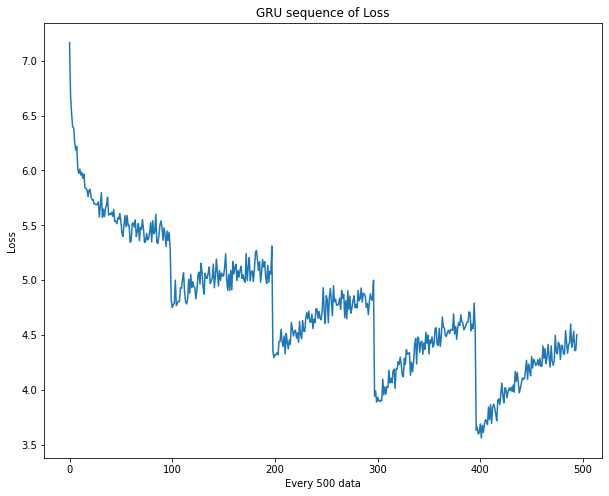

In [47]:
plt.figure(figsize=(10,8))
plt.plot(Loss_seq)
plt.title("GRU sequence of Loss")
plt.ylabel('Loss')
plt.xlabel('Every 500 data')

### Plot Accuracies Sequence through all the epochs

Text(0.5, 0, 'Every 500 data')

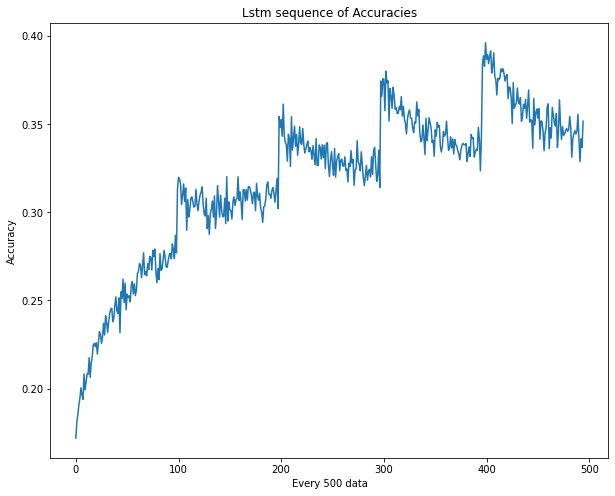

In [49]:
plt.figure(figsize=(10,8))
plt.plot(Acc_seq)
plt.title("Lstm sequence of Accuracies")
plt.ylabel('Accuracy')
plt.xlabel('Every 500 data')

## Evaluation of Model

In [51]:
sentence1 = "خرد تیره و مرد روشن روان"
sentence2 = "کسی کو خرد را ندارد ز پیش"

print("input sentence")
print(sentence1)
print("GRU output:")
print(ListToSentence(Evaluate(Encoder = encoderGru,Decoder = decoderGru,Sentence = sentence1, Max_Length = max_length, poem = poem)))

print("input sentence")
print(sentence2)
print("GRU output:")
print(ListToSentence(Evaluate(Encoder = encoderGru,Decoder = decoderGru,Sentence = sentence2, Max_Length = max_length, poem = poem)))

input sentence
خرد تیره و مرد روشن روان
GRU output:
آهنگ شیران نر 
input sentence
کسی کو خرد را ندارد ز پیش
GRU output:
وگر آز بودن نگیرد گذر 
